<a href="https://colab.research.google.com/github/CoolAstroWiz/PHYS3025Work/blob/main/PHYS_3025_Activity_1_CH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is adapted from Python tutorials by P. L. Lim, Adrian Price-Whelan, Kelle Cruz, and Stephanie T. Douglas with the AstroPy Foundation. I've modified them a bit to match our needs.
For the original cone search tutorial you can visit: https://learn.astropy.org/tutorials/conesearch.html . I've updated it to avoid errors and didn't use the last part but you can look there to see how to search more than one catalog at once and time the searches as well.
For the rest of the tutorial I based it on https://learn.astropy.org/tutorials/plot-catalog.html but the text files aren't available so we're using search methods to get data.

**The first few steps are just examples to get you started and learn the syntax for calling some of the tools in Astropy. Just click the arrow button to run the code. Note that you'll have to import each time you re-open the code.**

In [1]:
# Python standard library
import time
import warnings

# Third-party software
import numpy as np

# Astropy
from astropy import coordinates as coord
from astropy import units as u
from astropy.table import Table

# Astroquery. This tutorial requires 0.3.5 or greater.
!pip install astroquery #note we need to install it manually using !pip install
import astroquery
from astroquery.simbad import Simbad
from astroquery.vo_conesearch import conf, conesearch, vos_catalog

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.9/888.9 kB 29.0 MB/s eta 0:00:00


We'll be using ConeSearch first. To start, it might be useful to list the available Cone Search catalogs first. By default, catalogs that pass nightly validation are included. Validation is hosted by Space Telescope Science Institute (STScI).

In [2]:
conesearch.list_catalogs()

['2MASS All-Sky Catalog of Point Sources 1',
 'Gaia DR2 5',
 'Guide Star Catalog 2.3 Cone Search 1',
 'SDSS DR7 - Sloan Digital Sky Survey Data Release 7 1',
 'SDSS DR7 - Sloan Digital Sky Survey Data Release 7 2',
 'SDSS DR7 - Sloan Digital Sky Survey Data Release 7 3',
 'SDSS DR7 - Sloan Digital Sky Survey Data Release 7 4',
 'The HST Guide Star Catalog, Version 1.1 1',
 'The HST Guide Star Catalog, Version 1.2 1',
 'The HST Guide Star Catalog, Version GSC-ACT 1',
 'The PMM USNO-A1.0 Catalogue 1',
 'The USNO-A2.0 Catalogue 1',
 'The USNO-B1.0 Catalog 2',
 'Two Micron All Sky Survey (2MASS) 1',
 'Two Micron All Sky Survey (2MASS) 2']

Next, pick an astronomical object of interest. For example, M31. **You are not required to use the star you looked up on Simbad. It is okay to use M31 in these examples.**

In [3]:
c = coord.SkyCoord.from_name('NGC 869/884', frame='icrs')
print(c)

<SkyCoord (ICRS): (ra, dec) in deg
    (35.125, 57.13333333)>




By default, a basic Cone Search goes through the list of catalogs and stops at the first one that returns non-empty VO table. Let's search for objects within 0.1 degree around M31. You will see a lot of warnings that were generated by VO table parser but ignored by Cone Search service validator. VO compliance enforced by Cone Search providers is beyond the control of astroquery.vo_conesearch package.

The result is an[ Astropy](https://http://astropy.readthedocs.io/en/stable/table/index.html) table.


In [ ]:
result = conesearch.conesearch(c, 0.1 * u.degree)

In [ ]:
print('First non-empty table returned by', result.url)
print('Number of rows is', len(result))

In [ ]:
print(result)

This table can be manipulated like any other Astropy table; e.g., re-write the table into LaTeX format.

In [ ]:
result.write('my_result.tex', format='ascii.latex', overwrite=True)



You can now use your favorite text editor to open the my_result.tex file, but here, we are going to read it back into another Astropy table.

Note that the extra data_start=4 option is necessary due to the non-roundtripping nature of LaTeX reader/writer (see astropy issue [5205](https://github.com/astropy/astropy/issues/5205)).


In [ ]:
result_tex = Table.read('my_result.tex', format='ascii.latex', data_start=4)
print(result_tex)


Cone Search results can also be used in conjuction with other types of queries. For example, you can query SIMBAD for the first entry in your result above.


In [ ]:
# Due to the unpredictability of external services,
# The first successful query result (above) might differ
# from run to run.
#
# CHANGE THESE VALUES to the appropriate RA and DEC
# column names you see above, if necessary.
# These are for http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GSC23&
ra_colname = 'RAJ2000'
dec_colname = 'DEJ2000'
# Don't run this cell if column names above are invalid.
if ra_colname in result.colnames and dec_colname in result.colnames:
    row = result[0]
    simbad_obj = coord.SkyCoord(ra=row[ra_colname]*u.deg, dec=row[dec_colname]*u.deg)
    print('Searching SIMBAD for\n{}\n'.format(simbad_obj))
    simbad_result = Simbad.query_region(simbad_obj, radius=5*u.arcsec)
    print(simbad_result)
else:
    print('{} or {} not in search results. Choose from: {}'.format(
        ra_colname, dec_colname, ' '.join(result.colnames)))

Now back to Cone Search... You can extract metadata of this Cone Search catalog.

In [ ]:
my_db = vos_catalog.get_remote_catalog_db(conf.conesearch_dbname)
my_cat = my_db.get_catalog_by_url(result.url)
print(my_cat.dumps())

If you have a favorite catalog in mind, you can also perform Cone Search only on that catalog. A list of available catalogs can be obtained by calling conesearch.list_catalogs(), as mentioned above. For example 'The USNO-A2.0 Catalogue 1'

In [ ]:
try:
    result = conesearch.conesearch(
        c, 0.1 * u.degree, catalog_db='The USNO-A2.0 Catalogue 1')
except Exception as e:
    # We provide a cached version of the result table in case the query fails
    # due to an intermittent server-side issue, or if you do not have an
    # internet connection
    result = Table.read('usno-A2-result.fits')

print('Number of rows is', len(result))



Let's explore the 3 rows of astronomical objects found within 0.1 degree of M31 in the given catalog and sort them by increasing distance. For this example, the VO table has several columns that might include:

    _r = Angular distance (in degrees) between object and M31
    USNO-A2.0 = Catalog ID of the object
    RAJ2000 = Right ascension of the object (epoch=J2000)
    DEJ2000 = Declination of the object (epoch=J2000)

Note that column names, meanings, order, etc. might vary from catalog to catalog.


In [ ]:
col_names = result.colnames
print(col_names)



In [ ]:
# Before sort
print(result)



In [ ]:
# After sort
result.sort('_r')
print(result)



Now let's do some astrophysics. Suppose we wanted to make a plot



**Part 1)**

Let's look at stars in the  Perseus OB-1 double cluster.



1.  We're going to do a cone search of stars in the Gaia catalog ('Gaia DR2 5') and save to an ascii. Note that the search needs a name in the proper format so we're looking for NGC 869/884 which is one catalog name of the double cluster.
2.    It's pretty large but let's look within a tenth of a degree of the the cluster.
3.  To get the commands, use the examples we just did as a starting point. Also, print the column names as it will help you later. (see the result = consearch...) steps earlier in the tutorial.
4. Also you will probably want to print the column names to help with later steps.


In [4]:
c = coord.SkyCoord.from_name('NGC 869/884', frame='icrs')

In [6]:
try:
    result = conesearch.conesearch(
        c, 0.1 * u.degree, catalog_db='Gaia DR2 5')
except Exception as e:
    # We provide a cached version of the result table in case the query fails
    # due to an intermittent server-side issue, or if you do not have an
    # internet connection
    result = Table.read('usno-A2-result.fits')

print('Number of rows is', len(result))
col_names = result.colnames
print(col_names)

Trying http://vizier.unistra.fr/viz-bin/conesearch/I/345/gaia2?
Number of rows is 2068
['_r', 'DR2Name', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'SolID', 'Source', 'RandomI', 'Epoch', 'Plx', 'e_Plx', 'RPlx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'RADEcor', 'RAPlxcor', 'RApmRAcor', 'RApmDEcor', 'DEPlxcor', 'DEpmRAcor', 'DEpmDEcor', 'PlxpmRAcor', 'PlxpmDEcor', 'pmRApmDEcor', 'NAL', 'NAC', 'NgAL', 'NbAL', 'gofAL', 'chi2AL', 'epsi', 'sepsi', 'Solved', 'APF', 'WAL', 'pscol', 'e_pscol', 'fvarpi', 'MatchObsA', 'Nper', 'amax', 'type', 'MatchObs', 'Dup', 'o_Gmag', 'FG', 'e_FG', 'RFG', 'Gmag', 'e_Gmag', 'o_BPmag', 'FBP', 'e_FBP', 'RFBP', 'BPmag', 'e_BPmag', 'o_RPmag', 'FRP', 'e_FRP', 'RFRP', 'RPmag', 'e_RPmag', 'E_BR_RP_', 'Mode', 'BP-RP', 'BP-G', 'G-RP', 'RV', 'e_RV', 'o_RV', 'Tefftemp', 'loggtemp', '__Fe_H_temp', 'Var', 'GLON', 'GLAT', 'ELON', 'ELAT', 'fPriam', 'Teff', 'b_Teff', 'B_Teff', 'AG', 'b_AG', 'B_AG', 'E_BP-RP_', 'b_E_BP-RP_', 'B_E_BP-RP_', 'fFLAME', 'Rad', 'b_Rad', 'B_Rad', 'Lu

Let's save this as a csv.

In [7]:
result.write('my_result.csv', format='ascii.csv', overwrite=True)

Now let's read it. Note that if had a downloaded csv it might be a different command. See https://learn.astropy.org/tutorials/plot-catalog.html.

In [8]:
data = Table.read("my_result.csv")

Let's see the parallax column. You can use the command below to access the parallax column. The general syntax is data['*colname*'] where colname is the column you want to access using the naming we found when we printed the column names.

In [9]:
data['Plx']

1.0075
1.5114
0.2347
0.0721
0.9
0.5434
-0.1841
0.382
0.213
0.2433
0.0621


Note that we need to get rid of the negative parallaxes which are not physical. In reality we should figure out why they're negative but for now we'll just skip them. Use the command below.

In [10]:
data_clean=data[data["Plx"]>=0]

**Part 2**


1.   Covert the parallax column to distance in parsecs. Note that the unit of parallax for Gaia is mas (milli-arcsecond).
2.   In a cell below print the first three and last three distances in the table (that is distance of stars 0-2 and -3->-1).  The syntax is array[0:2] for the first three and array[-3:-1] for the last three. Python starts counting at 0, so entry 1 is cell 0. Likewise, to access cells we can also use reverse counting where the last cell is [-1].

In [11]:
#code for part 2 goes here
distance = 1/(data_clean['Plx']*1E-3)
print(distance[0:2])
print(distance[-3:-1])



       Plx       
-----------------
992.5558312655086
 661.638216223369
       Plx        
------------------
 878.4258608573435
1935.7336430507162


**Part 3**
Oh no! Not all the distances are the same as we'd expect for a star cluster (we'll talk about that!). I wonder if there's a difference between stars in the cluster and stars outside of it.


1.   Let's plot Right Ascension (RAJ2000) vs Declination (DEJ2000) and use distance  as a color axis to see if we ca find where those stars are.

 I have the paritial code below but it needs you to have calculated distance. Note we have to use log10 because of the spread between distances. Note, if you gave the distance variable a different name, you'll need to modify this.

Text(0, 0.5, 'DEC (deg)')

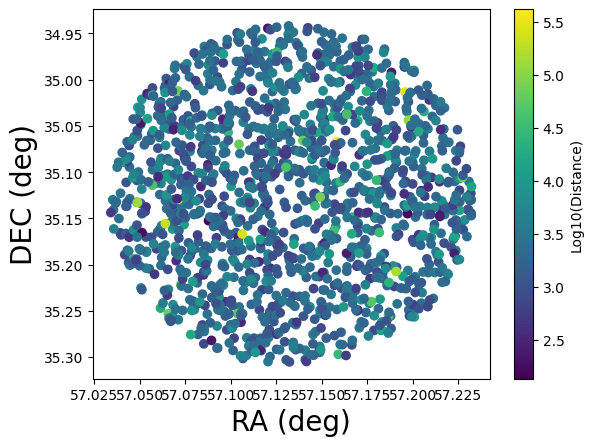

In [20]:
plt.scatter(data_clean["DEJ2000"],data_clean["RAJ2000"],c=np.log10(distance)) # plot J-K vs. J
cbar=plt.colorbar()
cbar.set_label('Log10(Distance)')
plt.ylim(reversed(plt.ylim())) # flip the y-axis
plt.xlabel("RA (deg)", fontsize=20)
plt.ylabel("DEC (deg)", fontsize=20)



**Part 4**
Okay, so that didn't really help!


1.  Try plotting either proper motion (pmRA vs pmDE) or Radial Velocity (RV) vs distance and write about what you observe. Keep distance as a color dimension. Proper motion is the apparent motion of a star whereas radial velocity is the line of sight motion. Stars in a cluster would be expected to have common motion...but even so it's not clear! There are some possible reaons for this.

2. After that, make a color-magnitude diagram by plotting BP-RP on X and absolute Gmag on Y. Let's keep distance as the color dimension.  **Keep in mind you'll need to calculate the absolute Gmag using the equaions from class! We'll talk more about what this plot says later in class.**

Text(0, 0.5, 'Proper Motion DE')

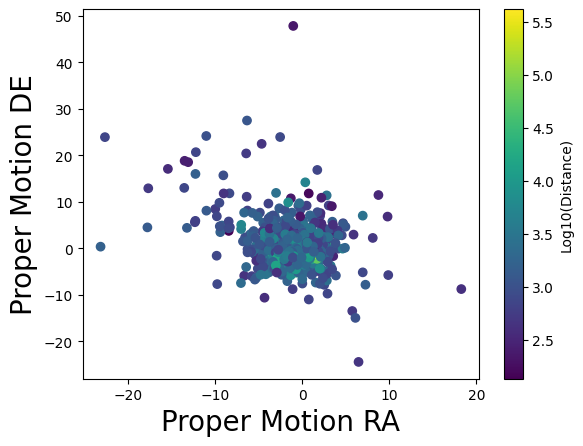

In [19]:
#i
plt.scatter(data_clean["pmDE"],data_clean["pmRA"],c=np.log10(distance)) # plot pmRA v. pmDE
cbar=plt.colorbar()
cbar.set_label('Log10(Distance)')
plt.xlabel("Proper Motion RA", fontsize=20)
plt.ylabel("Proper Motion DE", fontsize=20)

Text(0, 0.5, 'Gmag')

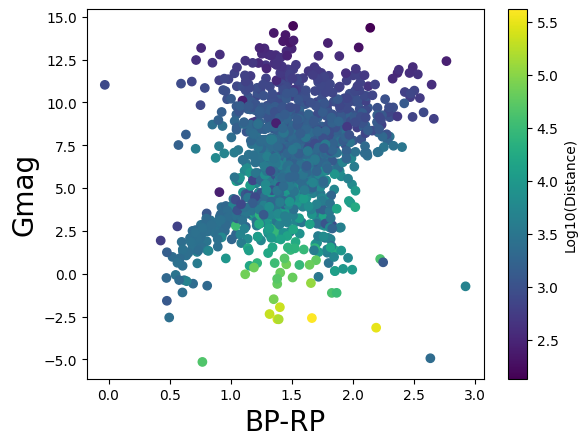

In [29]:
#ii
plt.scatter(data_clean["BP-RP"],(data_clean["Gmag"]-5*np.log10(distance)+5),c=np.log10(distance)) # plot BP-RP v. Gmag
cbar=plt.colorbar()
cbar.set_label('Log10(Distance)')
plt.xlabel("BP-RP", fontsize=20)
plt.ylabel("Gmag", fontsize=20)

**Part 5**
After this we'll do a few more plots.
1. Let's plot Temperature (Teff) vs Luminisoity (Lum);
2. Radius (Rad) vs Luminosity,
3.  Color (BP-RP) vs Teff.
4. Write a few sentences about what you observe.

Text(0, 0.5, 'Teff')

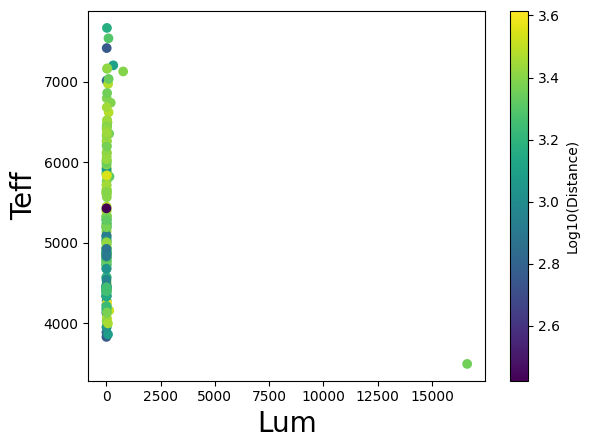

In [22]:
#i
plt.scatter(data_clean["Lum"],data_clean["Teff"],c=np.log10(distance)) # plot Teff vs. Lum
cbar=plt.colorbar()
cbar.set_label('Log10(Distance)')
plt.xlabel("Lum", fontsize=20)
plt.ylabel("Teff", fontsize=20)

Text(0, 0.5, 'Lum')

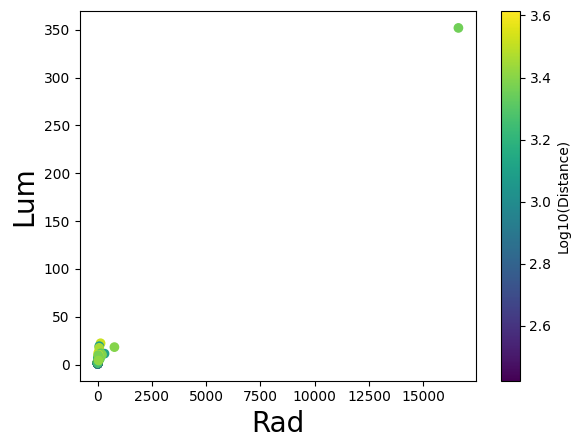

In [24]:
#ii
plt.scatter(data_clean["Lum"],data_clean["Rad"],c=np.log10(distance)) # plot Lum v. Rad
cbar=plt.colorbar()
cbar.set_label('Log10(Distance)')
plt.xlabel("Rad", fontsize=20)
plt.ylabel("Lum", fontsize=20)

Text(0, 0.5, 'BP-RP')

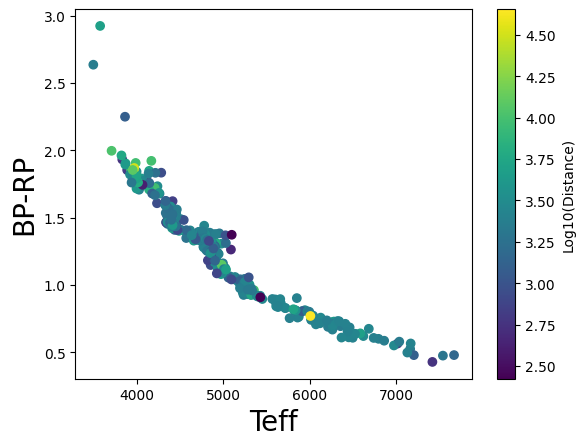

In [25]:
#iii
plt.scatter(data_clean["Teff"],data_clean["BP-RP"],c=np.log10(distance)) # plot BP-RP v. Teff
cbar=plt.colorbar()
cbar.set_label('Log10(Distance)')
plt.xlabel("Teff", fontsize=20)
plt.ylabel("BP-RP", fontsize=20)

The first two plotted graphs are pretty simple, without much variation in the luminosities or radii of the stars. In both of the first graphs I can see two outliers in the data, one with a very large luminosity and radius but a lower temperature. I can also see another slightly more luminous star which is also slightly larger than the majority of the cluster. However this small outlier also holds a much larger temperature compared to the rest of the cluster.

In the third plot, we can see a relationship between the temperature and the color output of the stars. For the most part, cooler stars will emit longer wavelengths, and the inverse also holds true. I also observe that there is a larger cluster around ~5000K, which could maybe tell us that this is a slightly more common temperature in this cluster.